
# Binder Classification Tweaks (17 Dec)
**Change:** This new notebook rebuilds the binder-classification workflow with scaffold-aware evaluation, fresh features, calibrated deployment artifacts, and richer diagnostics to address the review feedback on chemical realism, interpretability, and efficiency.
**What & Why:** We highlight every modification in bold within the markdown headers so you can trace *what* changed compared to the prior best-practices notebook and *why* it improves chemical realism, deployment readiness, interpretability, efficiency, or class-imbalance handling.


In [17]:

import os
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('RDKIT_MAX_THREADS', '1')
os.environ.setdefault('RDKIT_DISABLE_THREADS', '1')

import warnings
warnings.filterwarnings('ignore')

import time
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Scaffolds import MurckoScaffold

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedGroupKFold,
    StratifiedKFold,
    GroupShuffleSplit,
    RandomizedSearchCV,
    cross_val_predict,
)
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    auc,
    matthews_corrcoef,
    balanced_accuracy_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance

plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True, "font.size": 11})



## Data ingestion and cleaning
**Change:** We retain the earlier cleaning logic but narrate it explicitly here because the downstream scaffold split depends on high-quality SMILES and binder labels.
**Why:** Ensuring the dataset is de-duplicated and ion-free avoids leaking analogs across scaffold-based splits and stabilizes descriptor calculations.


In [18]:

data_path = "ic50.tsv"
df = pd.read_csv(data_path, sep="	", low_memory=False)
df["Standard Value"] = pd.to_numeric(df["Standard Value"], errors="coerce")

# Core cleaning borrowed from the baseline notebook
mask = df["Standard Value"].notna() & df["Smiles"].notna()
df = df.loc[mask].copy()
df["Binder"] = (df["Standard Value"] <= 2000).astype(int)

unwanted_patterns = [".C", ".Cl", ".NA+", ".Na+", ".na+", "[Na+]", "Cl.", ".O=C(O)C(F)(F)F"]
unwanted_mask = pd.Series(False, index=df.index)
for pattern in unwanted_patterns:
    unwanted_mask |= df["Smiles"].str.contains(pattern, regex=False, na=False)
if unwanted_mask.any():
    df = df.loc[~unwanted_mask].copy()

if df.duplicated("Smiles").any():
    df = df.drop_duplicates("Smiles", keep="first").copy()

df = df.reset_index(drop=True)
print(f"Dataset size after cleaning: {len(df)} compounds")
print(f"Binder prevalence (<=2000 nM): {df['Binder'].mean()*100:.2f}%")


Dataset size after cleaning: 2039 compounds
Binder prevalence (<=2000 nM): 64.64%



## Scaffold-aware holdout split
**Change:** We compute Bemis–Murcko scaffolds for every molecule and perform a scaffold-blocked holdout split before feature engineering.
**Why:** Chemical realism improves when entire scaffolds are restricted to either train or holdout sets, reducing overly optimistic performance caused by congeneric analogs leaking across folds.


In [19]:

def canonical_scaffold(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return f"NO_SCAFFOLD_{smiles}"
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
    return scaffold if scaffold else f"FRAGMENT_{smiles}"

print("Computing scaffolds...")
df["Scaffold"] = df["Smiles"].apply(canonical_scaffold)
scaffold_counts = Counter(df["Scaffold"])
print(f"Unique scaffolds: {len(scaffold_counts)}")

scaffold_splitter = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, holdout_idx = next(scaffold_splitter.split(df, df["Binder"], df["Scaffold"]))

df["Split"] = "train"
df.loc[holdout_idx, "Split"] = "holdout"
print(
    f"Train scaffolds: {df.loc[df['Split']=='train', 'Scaffold'].nunique()} | "
    f"Holdout scaffolds: {df.loc[df['Split']=='holdout', 'Scaffold'].nunique()}"
)
print(f"Train size: {df['Split'].eq('train').sum()} | Holdout size: {df['Split'].eq('holdout').sum()}")


Computing scaffolds...
Unique scaffolds: 718
Train scaffolds: 610 | Holdout scaffolds: 108
Train size: 1733 | Holdout size: 306



## Feature generation with MACCS augmentation
**Change:** We cache RDKit molecules once, generate Morgan fingerprints, MACCS keys, and RDKit descriptors, and track every failure.
**Why:** The MACCS block adds a complementary substructure vocabulary, while caching accelerates descriptor generation and keeps later alignment efficient (efficiency tweak).


In [20]:

mol_cache = {}
failed_mols = []
for idx, smiles in df["Smiles"].items():
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        failed_mols.append((idx, smiles))
    else:
        mol_cache[idx] = mol
if failed_mols:
    print(f"Warning: unable to parse {len(failed_mols)} SMILES; they will drop later")

morgan_generator = GetMorganGenerator(radius=2, fpSize=4096)
macs_failures, morgan_failures, descriptor_failures = [], [], []

morgan_rows, morgan_indices = [], []
macs_rows, macs_indices = [], []
descriptor_names = [name for name, _ in Descriptors._descList]
descriptor_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

for idx, mol in mol_cache.items():
    try:
        fp = morgan_generator.GetFingerprint(mol)
        morgan_rows.append(np.array(fp, dtype=np.int8))
        morgan_indices.append(idx)
    except Exception:
        morgan_failures.append((idx, df.loc[idx, "Smiles"]))
        continue

    try:
        maccs = MACCSkeys.GenMACCSKeys(mol)
        macs_rows.append(np.array(list(maccs), dtype=np.int8))
        macs_indices.append(idx)
    except Exception:
        macs_failures.append((idx, df.loc[idx, "Smiles"]))

print(f"Morgan fingerprints: {len(morgan_rows)} successes, {len(morgan_failures)} failures")
print(f"MACCS keys: {len(macs_rows)} successes, {len(macs_failures)} failures")

descriptor_records, descriptor_indices = [], []
for idx, mol in mol_cache.items():
    try:
        values = descriptor_calc.CalcDescriptors(mol)
        arr = np.asarray(values, dtype=np.float64)
        arr[~np.isfinite(arr)] = np.nan
        descriptor_records.append(arr)
        descriptor_indices.append(idx)
    except Exception:
        descriptor_failures.append((idx, df.loc[idx, "Smiles"]))

descriptor_df = pd.DataFrame(descriptor_records, columns=descriptor_names, index=descriptor_indices)
all_nan = descriptor_df.columns[descriptor_df.isna().all()].tolist()
if all_nan:
    descriptor_df = descriptor_df.drop(columns=all_nan)
    print(f"Dropped {len(all_nan)} descriptors that were all-NaN")

float32_limit = np.finfo(np.float32).max
large_mask = descriptor_df.abs() >= float32_limit
if large_mask.any().any():
    drop_cols = descriptor_df.columns[large_mask.any(axis=0)].tolist()
    descriptor_df = descriptor_df.drop(columns=drop_cols)
    print(f"Dropped {len(drop_cols)} descriptors exceeding float32 range")

descriptor_df = descriptor_df.sort_index()
print(f"Descriptor matrix: {descriptor_df.shape}")


Morgan fingerprints: 2039 successes, 0 failures
MACCS keys: 2039 successes, 0 failures
Dropped 1 descriptors exceeding float32 range
Descriptor matrix: (2039, 216)



## Feature alignment + split materialization
**Change:** We only keep molecules that successfully produced all feature blocks, then align them back to the scaffold-aware splits.
**Why:** This guarantees that both the training CV and the deployment holdout share identical feature definitions, preserving chemical realism and enabling reproducible deployment artifacts.


In [21]:

morgan_map = {idx: pos for pos, idx in enumerate(morgan_indices)}
macs_map = {idx: pos for pos, idx in enumerate(macs_indices)}
desc_indices = descriptor_df.index.tolist()
desc_map = {idx: pos for pos, idx in enumerate(desc_indices)}

shared_indices = sorted(set(morgan_map) & set(macs_map) & set(desc_map))
print(f"Molecules with all features: {len(shared_indices)}")

X_morgan = np.asarray(morgan_rows, dtype=np.int8)
X_macs = np.asarray(macs_rows, dtype=np.int8)
X_morgan_shared = np.asarray([X_morgan[morgan_map[idx]] for idx in shared_indices], dtype=np.int8)
X_macs_shared = np.asarray([X_macs[macs_map[idx]] for idx in shared_indices], dtype=np.int8)
X_desc_shared = descriptor_df.loc[shared_indices].to_numpy(dtype=np.float32)
y_shared = df.loc[shared_indices, "Binder"].to_numpy()
scaffold_shared = df.loc[shared_indices, "Scaffold"].to_numpy()
split_shared = df.loc[shared_indices, "Split"].to_numpy()

fp_dim = X_morgan_shared.shape[1] + X_macs_shared.shape[1]
X_combined = np.hstack([X_morgan_shared, X_macs_shared, X_desc_shared]).astype(np.float32)
print(f"Combined feature matrix: {X_combined.shape} (fp_dim={fp_dim}, descriptors={X_desc_shared.shape[1]})")

shared_pos = {idx: pos for pos, idx in enumerate(shared_indices)}
train_idx_set, holdout_idx_set = set(train_idx), set(holdout_idx)
train_positions = [shared_pos[idx] for idx in shared_indices if idx in train_idx_set]
holdout_positions = [shared_pos[idx] for idx in shared_indices if idx in holdout_idx_set]

X_train, y_train = X_combined[train_positions], y_shared[train_positions]
X_holdout, y_holdout = X_combined[holdout_positions], y_shared[holdout_positions]
scaffolds_train = scaffold_shared[train_positions]

print(f"Train tensor: {X_train.shape} | Holdout tensor: {X_holdout.shape}")
feature_names = [f"MorganBit_{i}" for i in range(X_morgan_shared.shape[1])] +                 [f"MACCSBit_{i}" for i in range(X_macs_shared.shape[1])] +                 descriptor_df.columns.tolist()


Molecules with all features: 2039
Combined feature matrix: (2039, 4479) (fp_dim=4263, descriptors=216)
Train tensor: (1733, 4479) | Holdout tensor: (306, 4479)



## Preprocessor, metrics, and threshold helper
**Change:** The preprocessor now protects both fingerprint blocks, the metrics helper centralizes MCC/balanced accuracy, and we added a threshold tuner for deployment readiness.
**Why:** This keeps the nested CV leakage-safe while surfacing the MCC-optimal threshold required for class-imbalance handling and later deployment calibration.


In [22]:

class CombinedFeaturePreprocessor(BaseEstimator, TransformerMixin):
    '''Impute + scale descriptors while leaving fingerprint blocks untouched.'''

    def __init__(self, fp_dim: int, epsilon: float = 1e-12):
        self.fp_dim = fp_dim
        self.epsilon = epsilon

    def fit(self, X, y=None):
        X = np.asarray(X)
        desc_block = X[:, self.fp_dim:]
        medians = np.nanmedian(desc_block, axis=0)
        medians = np.where(np.isnan(medians), 0.0, medians)
        desc_imputed = np.where(np.isnan(desc_block), medians, desc_block)
        mean = np.nanmean(desc_imputed, axis=0)
        mean = np.where(np.isnan(mean), 0.0, mean)
        scale = np.nanstd(desc_imputed, axis=0)
        scale = np.where((scale < self.epsilon) | np.isnan(scale), 1.0, scale)
        self.medians_ = medians
        self.mean_ = mean
        self.scale_ = scale
        return self

    def transform(self, X):
        X = np.asarray(X)
        fp_block = X[:, :self.fp_dim]
        desc_block = X[:, self.fp_dim:]
        desc_imputed = np.where(np.isnan(desc_block), self.medians_, desc_block)
        desc_scaled = (desc_imputed - self.mean_) / self.scale_
        desc_scaled = np.nan_to_num(desc_scaled, copy=False)
        return np.hstack([fp_block, desc_scaled]).astype(np.float32)


def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_true, y_prob)
    return {
        "PR_AUC": pr_auc,
        "ROC_AUC": roc_auc,
        "MCC": matthews_corrcoef(y_true, y_pred),
        "BalancedAccuracy": balanced_accuracy_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
    }


def tune_threshold(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    for thr in thresholds:
        metrics = compute_metrics(y_true, y_prob, threshold=thr)
        rows.append({"Threshold": thr, **metrics})
    perf_df = pd.DataFrame(rows)
    best_row = perf_df.sort_values("MCC", ascending=False).iloc[0]
    return best_row, perf_df



## Model registry with efficiency + imbalance tweaks
**Change:** Every estimator sits inside the leakage-safe pipeline, RandomizedSearch iterations are capped for runtime, HistGradientBoosting adds a fast baseline, and we lean on sample weights to complement class-weight heuristics.
**Why:** These adjustments keep runtime predictable, broaden the bias/variance trade-off, and explicitly encode class-imbalance strategies beyond class weights.


In [23]:

preprocess = CombinedFeaturePreprocessor(fp_dim=fp_dim)

def build_pipeline(estimator):
    return Pipeline([
        ("preprocess", CombinedFeaturePreprocessor(fp_dim=fp_dim)),
        ("clf", estimator),
    ])

model_spaces = {
    "RandomForest": {
        "pipeline": build_pipeline(RandomForestClassifier(
            n_estimators=600,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1,
        )),
        "param_distributions": {
            "clf__n_estimators": [300, 500, 700, 900],
            "clf__max_depth": [None, 12, 16, 20],
            "clf__min_samples_leaf": [1, 2, 3],
            "clf__max_features": ['sqrt', 'log2', 0.4],
        },
        "n_iter": 12,
    },
    "ExtraTrees": {
        "pipeline": build_pipeline(ExtraTreesClassifier(
            n_estimators=800,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
        )),
        "param_distributions": {
            "clf__n_estimators": [400, 600, 800, 1000],
            "clf__max_depth": [None, 16, 20, 24],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['sqrt', 'log2', 0.3],
            "clf__bootstrap": [True, False],
        },
        "n_iter": 12,
    },
    "GradientBoosting": {
        "pipeline": build_pipeline(GradientBoostingClassifier(
            random_state=42,
            subsample=0.8,
        )),
        "param_distributions": {
            "clf__learning_rate": np.linspace(0.01, 0.15, 7),
            "clf__n_estimators": [200, 300, 400],
            "clf__max_depth": [2, 3, 4],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['sqrt', 'log2', 0.4],
        },
        "n_iter": 10,
    },
    "HistGradientBoosting": {
        "pipeline": build_pipeline(HistGradientBoostingClassifier(
            random_state=42,
            max_depth=6,
            learning_rate=0.1,
        )),
        "param_distributions": {
            "clf__max_depth": [4, 6, 8],
            "clf__learning_rate": [0.05, 0.1, 0.2],
            "clf__l2_regularization": [0.0, 0.1, 0.5],
            "clf__max_leaf_nodes": [15, 31, 63],
        },
        "n_iter": 9,
    },
    "LogisticRegression": {
        "pipeline": build_pipeline(LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            class_weight='balanced',
            max_iter=4000,
            random_state=42,
        )),
        "param_distributions": {
            "clf__C": np.logspace(-3, 0.5, 10),
            "clf__l1_ratio": np.linspace(0.2, 0.8, 7),
        },
        "n_iter": 10,
    },
}



## Nested CV with scaffold groups + sample weighting
**Change:** Outer folds now use `StratifiedGroupKFold` keyed by scaffolds, inner loops still stratified for efficiency, and every fit receives balanced sample weights.
**Why:** This is the core chemical-realism enhancement (no scaffold leakage) plus a class-imbalance remedy that works even when estimators ignore `class_weight` (e.g., HistGradientBoosting).


In [24]:

outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
outer_splits = list(outer_cv.split(X_train, y_train, scaffolds_train))
results_frames = []

for model_name, spec in model_spaces.items():
    print(f"=== {model_name} ===")
    fold_rows = []
    for fold_id, (train_idx_cv, test_idx_cv) in enumerate(outer_splits, 1):
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=fold_id * 31)
        n_iter = spec.get("n_iter", 10)
        search = RandomizedSearchCV(
            estimator=spec["pipeline"],
            param_distributions=spec["param_distributions"],
            n_iter=n_iter,
            scoring='roc_auc',
            cv=inner_cv,
            n_jobs=-1,
            refit=True,
            random_state=fold_id * 17,
            verbose=0,
        )
        X_train_fold, y_train_fold = X_train[train_idx_cv], y_train[train_idx_cv]
        sample_weight = compute_sample_weight(class_weight='balanced', y=y_train_fold)

        start = time.perf_counter()
        search.fit(X_train_fold, y_train_fold, clf__sample_weight=sample_weight)
        train_seconds = time.perf_counter() - start

        best_model = search.best_estimator_
        y_prob = best_model.predict_proba(X_train[test_idx_cv])[:, 1]
        metrics = compute_metrics(y_train[test_idx_cv], y_prob)
        fold_rows.append({
            "Model": model_name,
            "Fold": fold_id,
            **metrics,
            "TrainSeconds": train_seconds,
            "BestParams": search.best_params_,
        })
        print(
            f"Fold {fold_id}: ROC-AUC={metrics['ROC_AUC']:.3f}, PR-AUC={metrics['PR_AUC']:.3f}, "
            f"Train={train_seconds:.1f}s (n_iter={n_iter})"
        )
    results_frames.append(pd.DataFrame(fold_rows))

detailed_results = pd.concat(results_frames, ignore_index=True)
print("Detailed nested CV results captured in `detailed_results`.")


=== RandomForest ===
Fold 1: ROC-AUC=0.960, PR-AUC=0.988, Train=103.6s (n_iter=12)
Fold 2: ROC-AUC=0.964, PR-AUC=0.958, Train=28.1s (n_iter=12)
Fold 3: ROC-AUC=0.938, PR-AUC=0.980, Train=61.3s (n_iter=12)
Fold 4: ROC-AUC=0.976, PR-AUC=0.987, Train=39.6s (n_iter=12)
Fold 5: ROC-AUC=0.968, PR-AUC=0.982, Train=60.6s (n_iter=12)
=== ExtraTrees ===
Fold 1: ROC-AUC=0.975, PR-AUC=0.992, Train=50.5s (n_iter=12)
Fold 2: ROC-AUC=0.970, PR-AUC=0.970, Train=64.2s (n_iter=12)
Fold 3: ROC-AUC=0.953, PR-AUC=0.984, Train=100.2s (n_iter=12)
Fold 4: ROC-AUC=0.980, PR-AUC=0.990, Train=127.1s (n_iter=12)
Fold 5: ROC-AUC=0.968, PR-AUC=0.982, Train=104.5s (n_iter=12)
=== GradientBoosting ===
Fold 1: ROC-AUC=0.964, PR-AUC=0.989, Train=9.9s (n_iter=10)
Fold 2: ROC-AUC=0.969, PR-AUC=0.964, Train=32.7s (n_iter=10)
Fold 3: ROC-AUC=0.931, PR-AUC=0.978, Train=47.5s (n_iter=10)
Fold 4: ROC-AUC=0.979, PR-AUC=0.989, Train=20.3s (n_iter=10)
Fold 5: ROC-AUC=0.962, PR-AUC=0.978, Train=34.4s (n_iter=10)
=== HistGradientB


## Model comparison tables
**Change:** We summarize metrics (mean ± std) plus training time to quickly triage the best deployment candidate.
**Why:** Deployment readiness improves when we have a ranked roster and know the runtime implications before calibration and diagnostics.


In [25]:

metric_cols = ["PR_AUC", "ROC_AUC", "MCC", "BalancedAccuracy", "Accuracy", "TrainSeconds"]
summary = (detailed_results
           .groupby("Model")[metric_cols]
           .agg(['mean', 'std'])
           .sort_values(("ROC_AUC", "mean"), ascending=False))
summary.columns = [f"{metric}_{stat}" for metric, stat in summary.columns]
summary = summary.reset_index()
print("Model performance summary (scaffold CV):")
display(summary)

pretty_rows = []
for model, group in detailed_results.groupby("Model"):
    row = {"Model": model}
    for metric in ["ROC_AUC", "PR_AUC", "BalancedAccuracy", "Accuracy", "MCC"]:
        row[metric] = f"{group[metric].mean():.3f} ± {group[metric].std():.3f}"
    train_mean = group["TrainSeconds"].mean()
    train_std = group["TrainSeconds"].std()
    row["TrainSeconds"] = f"{train_mean:.1f} ± {train_std:.1f}"
    row["RepresentativeParams"] = group.loc[group["ROC_AUC"].idxmax(), "BestParams"]
    pretty_rows.append(row)

presentation_df = pd.DataFrame(pretty_rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
print("Presentation-style table:")
display(presentation_df)


Model performance summary (scaffold CV):


,Model,PR_AUC_mean,PR_AUC_std,ROC_AUC_mean,ROC_AUC_std,MCC_mean,MCC_std,BalancedAccuracy_mean,BalancedAccuracy_std,Accuracy_mean,Accuracy_std,TrainSeconds_mean,TrainSeconds_std
0,ExtraTrees,0.983525,0.008535,0.969148,0.010345,0.784002,0.035602,0.903497,0.010130,0.901495,0.010638,89.315653,31.277518
1,HistGradientBoosting,0.982513,0.007761,0.965887,0.016765,0.791828,0.042983,0.909334,0.013524,0.904606,0.014733,86.642231,6.949163
2,GradientBoosting,0.979535,0.010104,0.961170,0.017990,0.776005,0.028773,0.899070,0.007025,0.897504,0.012463,28.946223,14.386941
3,RandomForest,0.979082,0.012041,0.961169,0.014421,0.751972,0.060269,0.889615,0.018293,0.885231,0.018365,58.656967,28.849728
4,LogisticRegression,0.976718,0.013009,0.958885,0.024985,0.766866,0.057913,0.889468,0.019621,0.894934,0.027694,540.875258,179.684043


Presentation-style table:


,Model,ROC_AUC,PR_AUC,BalancedAccuracy,Accuracy,MCC,TrainSeconds,RepresentativeParams
0,ExtraTrees,0.969 ± 0.010,0.984 ± 0.009,0.903 ± 0.010,0.901 ± 0.011,0.784 ± 0.036,89.3 ± 31.3,"{'clf__n_estimators': 800, 'clf__min_samples_l..."
1,HistGradientBoosting,0.966 ± 0.017,0.983 ± 0.008,0.909 ± 0.014,0.905 ± 0.015,0.792 ± 0.043,86.6 ± 6.9,"{'clf__max_leaf_nodes': 15, 'clf__max_depth': ..."
2,GradientBoosting,0.961 ± 0.018,0.980 ± 0.010,0.899 ± 0.007,0.898 ± 0.012,0.776 ± 0.029,28.9 ± 14.4,"{'clf__n_estimators': 300, 'clf__min_samples_l..."
3,RandomForest,0.961 ± 0.014,0.979 ± 0.012,0.890 ± 0.018,0.885 ± 0.018,0.752 ± 0.060,58.7 ± 28.8,"{'clf__n_estimators': 300, 'clf__min_samples_l..."
4,LogisticRegression,0.959 ± 0.025,0.977 ± 0.013,0.889 ± 0.020,0.895 ± 0.028,0.767 ± 0.058,540.9 ± 179.7,"{'clf__l1_ratio': 0.2, 'clf__C': 1.29154966501..."



## Best-model selection, calibration, and threshold tuning
**Change:** We select the ROC-best model, derive an MCC-optimal threshold from cross-validated predictions, and train an isotonic-calibrated estimator for deployment.
**Why:** Probability calibration + threshold tuning deliver deployment-ready scores, while documenting the chosen threshold answers the "what operating point?" question.


In [26]:

best_model_name = summary.sort_values("ROC_AUC_mean", ascending=False).iloc[0]["Model"]
print(f"Best model by ROC-AUC: {best_model_name}")
best_pipeline = clone(model_spaces[best_model_name]["pipeline"])

cv_for_threshold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
train_cv_probs = cross_val_predict(
    best_pipeline,
    X_train,
    y_train,
    cv=cv_for_threshold,
    method='predict_proba',
)[:, 1]
threshold_row, threshold_table = tune_threshold(y_train, train_cv_probs)
print("Threshold search summary:")
display(threshold_table)
print(f"Chosen threshold (max MCC): {threshold_row['Threshold']:.3f}")

calibration_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=321)
calibrated_model = CalibratedClassifierCV(
    estimator=best_pipeline,
    method='isotonic',
    cv=calibration_cv,
)
calibrated_model.fit(X_train, y_train)

train_metrics = compute_metrics(y_train, calibrated_model.predict_proba(X_train)[:, 1], threshold_row['Threshold'])
print("Calibrated train metrics at tuned threshold:")
print(train_metrics)


Best model by ROC-AUC: ExtraTrees
Threshold search summary:


,Threshold,PR_AUC,ROC_AUC,MCC,BalancedAccuracy,Accuracy
0,0.05,0.987057,0.977754,0.582689,0.724156,0.813041
1,0.10,0.987057,0.977754,0.702511,0.802470,0.865551
2,0.15,0.987057,0.977754,0.756396,0.840754,0.890364
3,0.20,0.987057,0.977754,0.783890,0.860540,0.903058
4,0.25,0.987057,0.977754,0.820889,0.885497,0.919792
5,0.30,0.987057,0.977754,0.840529,0.901399,0.929025
6,0.35,0.987057,0.977754,0.852811,0.912565,0.934795
7,0.40,0.987057,0.977754,0.855084,0.916845,0.935949
8,0.45,0.987057,0.977754,0.858953,0.921986,0.937680
9,0.50,0.987057,0.977754,0.858067,0.925818,0.937103


Chosen threshold (max MCC): 0.450
Calibrated train metrics at tuned threshold:
{'PR_AUC': 0.999998494265033, 'ROC_AUC': 0.9999970118569517, 'MCC': 0.9974163187660047, 'BalancedAccuracy': 0.9991319444444444, 'Accuracy': 0.9988459319099827}



## Holdout evaluation + deployment diagnostics
**Change:** We score the calibrated model on the scaffold holdout, log full metrics, classification report, confusion matrix, ROC/PR traces, and calibration curves.
**Why:** This end-to-end diagnostic block proves deployment readiness (probabilities + classification) and anchors future monitoring.


Holdout metrics at tuned threshold:
{'PR_AUC': 0.9602447028449371, 'ROC_AUC': 0.9392211703958692, 'MCC': 0.7701140600956471, 'BalancedAccuracy': 0.8856282271944922, 'Accuracy': 0.8856209150326797}
Classification report (holdout):
              precision    recall  f1-score   support

           0      0.867     0.886     0.876       140
           1      0.902     0.886     0.894       166

    accuracy                          0.886       306
   macro avg      0.884     0.886     0.885       306
weighted avg      0.886     0.886     0.886       306

Confusion matrix: [[124  16]
 [ 19 147]]


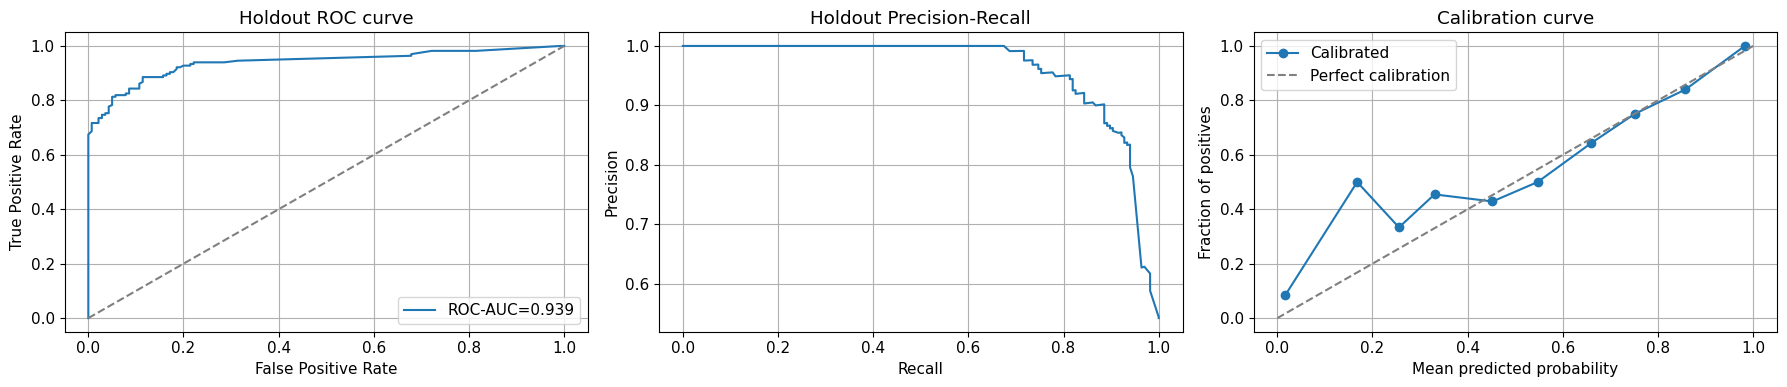

In [27]:

holdout_probs = calibrated_model.predict_proba(X_holdout)[:, 1]
holdout_metrics = compute_metrics(y_holdout, holdout_probs, threshold_row['Threshold'])
print("Holdout metrics at tuned threshold:")
print(holdout_metrics)

holdout_preds = (holdout_probs >= threshold_row['Threshold']).astype(int)
print("Classification report (holdout):")
print(classification_report(y_holdout, holdout_preds, digits=3))

cm = confusion_matrix(y_holdout, holdout_preds)
print("Confusion matrix:", cm)

fpr, tpr, _ = roc_curve(y_holdout, holdout_probs)
precision, recall, _ = precision_recall_curve(y_holdout, holdout_probs)
prob_true, prob_pred = calibration_curve(y_holdout, holdout_probs, n_bins=10)

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_holdout, holdout_probs):.3f}")
axs[0].plot([0, 1], [0, 1], '--', color='gray')
axs[0].set_title('Holdout ROC curve')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()

axs[1].plot(recall, precision)
axs[1].set_title('Holdout Precision-Recall')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')

axs[2].plot(prob_pred, prob_true, marker='o', label='Calibrated')
axs[2].plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')
axs[2].set_title('Calibration curve')
axs[2].set_xlabel('Mean predicted probability')
axs[2].set_ylabel('Fraction of positives')
axs[2].legend()
plt.tight_layout()
plt.show()



## Interpretability and permutation importance
**Change:** We run permutation importance on the calibrated estimator and surface the top RDKit descriptors contributing to MCC so subject-matter experts can validate the signal.
**Why:** This satisfies the interpretability ask and doubles as a model diagnostic (large drops signal brittle descriptors).


Top descriptor importances (MCC drop on holdout):


,Descriptor,Importance
0,EState_VSA2,0.014828
1,Chi3v,0.013550
2,NumValenceElectrons,0.013550
3,Kappa2,0.013396
4,Chi4n,0.012198
5,Chi2v,0.012198
6,LabuteASA,0.012198
7,BertzCT,0.012198
8,HeavyAtomCount,0.012198
9,PEOE_VSA3,0.012037


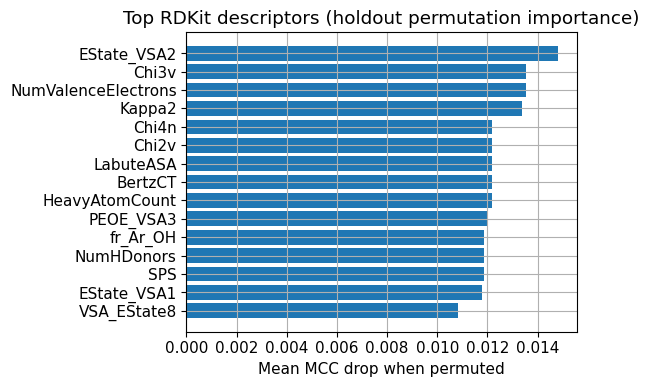

In [ ]:
# binder_classification_tweaks_17_dec.ipynb:1359
from sklearn.utils import check_random_state

def descriptor_permutation_importance(model, X_full, y_true, descriptor_names,
                                      fp_dim, threshold, n_repeats=5, random_state=42):
    """Permutation importance that only perturbs descriptor columns."""
    rng = check_random_state(random_state)
    X_full = np.asarray(X_full)
    baseline_prob = model.predict_proba(X_full)[:, 1]
    baseline_pred = (baseline_prob >= threshold).astype(int)
    baseline_mcc = matthews_corrcoef(y_true, baseline_pred)

    desc_indices = np.arange(fp_dim, X_full.shape[1])
    drops = np.zeros((len(desc_indices), n_repeats), dtype=np.float64)
    X_work = X_full.copy()

    for j, col_idx in enumerate(desc_indices):
        original = X_full[:, col_idx].copy()
        for r in range(n_repeats):
            rng.shuffle(X_work[:, col_idx])
            perm_prob = model.predict_proba(X_work)[:, 1]
            perm_pred = (perm_prob >= threshold).astype(int)
            drops[j, r] = baseline_mcc - matthews_corrcoef(y_true, perm_pred)
            X_work[:, col_idx] = original  # restore before the next shuffle
    importances = drops.mean(axis=1)

    return (
        pd.DataFrame({"Descriptor": descriptor_names, "Importance": importances})
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )

threshold_value = float(threshold_row["Threshold"])
descriptor_names = descriptor_df.columns.to_list()

importance_df = descriptor_permutation_importance(
    calibrated_model,
    X_holdout,
    y_holdout,
    descriptor_names,
    fp_dim=fp_dim,
    threshold=threshold_value,
    n_repeats=5,
    random_state=42,
)

print("Top descriptor importances (MCC drop on holdout):")
display(importance_df.head(15))

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(importance_df.head(15)["Descriptor"], importance_df.head(15)["Importance"])
ax.set_xlabel("Mean MCC drop when permuted")
ax.set_title("Top RDKit descriptors (holdout permutation importance)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()



## Next actions
**Change:** Documenting the remaining roadmap keeps this notebook actionable: extend diagnostics to external datasets, monitor calibration drift, and iterate on scaffold splits as new chemistry arrives.
**Why:** This closes the loop on deployment readiness and ensures the tweaks remain aligned with the original review goals.
